<a href="https://colab.research.google.com/github/kairavkkp/ML-Tutorials/blob/neural-style-transfer/Neural_Style_Transfer/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer GAN.

Link for Official Tutorial: [Link](https://www.tensorflow.org/tutorials/generative/style_transfer) 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import tensorflow as tf

os.chdir('/content/drive/MyDrive/Neural_Style_Transfer')

# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [143]:
## Downloading Images
content_path = tf.keras.utils.get_file(os.path.join(os.getcwd(),'Mountains.jpeg'),'https://firebasestorage.googleapis.com/v0/b/merge-my-pdf.appspot.com/o/mountain_house.jpeg?alt=media&token=c072059d-04b2-4249-9cbc-b2efd9ff98ee')
# style_path = tf.keras.utils.get_file(os.path.join(os.getcwd(),'kandinsky5.jpg'),'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
# content_path = tf.keras.utils.get_file(os.path.join(os.getcwd(),'person.jpeg'),'https://firebasestorage.googleapis.com/v0/b/merge-my-pdf.appspot.com/o/person.jpeg?alt=media&token=75260f18-1dd8-4236-9a15-cd68c8fb36e2')
# style_path = tf.keras.utils.get_file(os.path.join(os.getcwd(),'style-2.jpg'), 'https://firebasestorage.googleapis.com/v0/b/merge-my-pdf.appspot.com/o/finger-1.jpg?alt=media&token=d6dca7d4-ad4e-4855-811e-9fc9f638b3ce')
style_path = tf.keras.utils.get_file(os.path.join(os.getcwd(),'shaing.jpg'),'https://firebasestorage.googleapis.com/v0/b/merge-my-pdf.appspot.com/o/shading.jpg?alt=media&token=fc3d1198-8750-44eb-bc01-dd4479dcb00a')

## Visualize the input

In [144]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale , tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img


In [145]:
## Display Image function

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  
  plt.imshow(image)
  if title:
    plt.title(title)

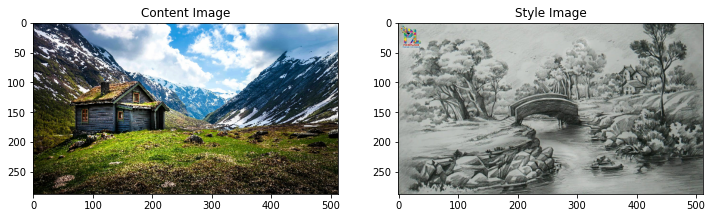

In [146]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1,2,1)
imshow(content_image, "Content Image")

plt.subplot(1,2,2)
imshow(style_image, "Style Image")

In [147]:
import tensorflow_hub as hub

In [148]:
def tensor_to_image(tensor):
  tensor = tensor * 255
  tensor = np.array(tensor, np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return Image.fromarray(tensor)

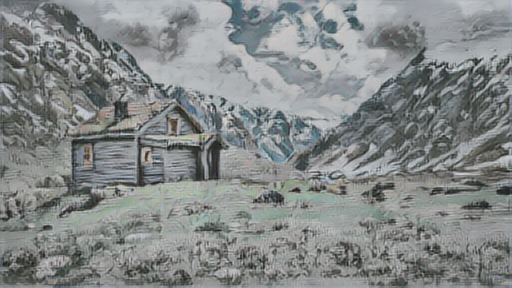

In [149]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Define content and style Representation

In [150]:
## Loading VGG19 and testing it on our image

x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [151]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('alp', 0.86953163),
 ('valley', 0.11097444),
 ('mountain_tent', 0.012070098),
 ('barn', 0.003150953),
 ('boathouse', 0.0015213969)]

In [152]:
# Loading VGG19 model without Head (Top)
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)




input_14
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [153]:
# Choosing Intermediate layers for style and content of the images.

content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']


num_content_layers = len(content_layers)
num_style_layers = len(style_layers)



In [154]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(layer).output for layer in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [155]:
## Creating Model

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()


block1_conv1
  shape:  (1, 288, 512, 64)
  min:  0.0
  max:  722.8341
  mean:  27.405573

block2_conv1
  shape:  (1, 144, 256, 128)
  min:  0.0
  max:  3195.0767
  mean:  170.09645

block3_conv1
  shape:  (1, 72, 128, 256)
  min:  0.0
  max:  7177.008
  mean:  146.0316

block4_conv1
  shape:  (1, 36, 64, 512)
  min:  0.0
  max:  15991.863
  mean:  554.93414

block5_conv1
  shape:  (1, 18, 32, 512)
  min:  0.0
  max:  2264.232
  mean:  37.408836



## Calculate Style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

Here, $F_{ij}^{l}$, is the activation of $i^{th}$ filter at the position ${j}$ for layer ${l}$. Here, $c$ and $d$ are the same tensors and the Gram Matrix is doing outer product for feature vectors with itself.

$$G_{cd}^{l} = \frac{\Sigma_{ij}F_{ijc}^{l}(x)F_{ijd}^{l}(x)}{IJ}$$

In [156]:
## Using Ein SUM to calculate Gram Matrix
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc, bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [157]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    """
    Expects float input in the interval of [0,1]
    """
    inputs = inputs*255
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)

    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
    
    style_outputs = [gram_matrix(style_output) 
                      for style_output in style_outputs]
    content_dict = {
        content_name:value 
        for content_name, value in zip(self.content_layers, content_outputs)
    }

    style_dict = {
        style_name:value
        for style_name, value in zip(self.style_layers, style_outputs)
    }

    return {"content":content_dict, "style":style_dict}
    

Return gram_matrix of `style_layers` and content from the `content_layers`.

In [158]:
extractor = StyleContentModel(style_layers, content_layers)

In [159]:
results = extractor(tf.constant(content_image))

In [160]:
print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.50318515
    max:  30016.375
    mean:  1079.4152

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  394776.7
    mean:  36344.625

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  757589.5
    mean:  29759.377

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  9489554.0
    mean:  425998.56

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  190550.33
    mean:  2568.5996

Contents:
   block5_conv2
    shape:  (1, 18, 32, 512)
    min:  0.0
    max:  1725.4067
    mean:  18.874073


## Running Gradient Descent

In [161]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [162]:
## Placeholder for optimization
image = tf.Variable(content_image)

In [163]:
## Keep values between 0 and 1
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [164]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [165]:
# Co-efficients for Weighted Loss.
style_weight = 1e-2
content_weight = 1e4

In [166]:
## Loss
def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n(
      [
       tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
       for  name in style_outputs.keys()
      ]
  )
  style_loss *= style_weight / num_style_layers

  content_loss = tf.add_n(
      [
        tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
        for name in content_outputs.keys()
      ]
  )

  content_loss *= content_weight / num_content_layers

  loss = style_loss + content_loss
  return loss

In [167]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

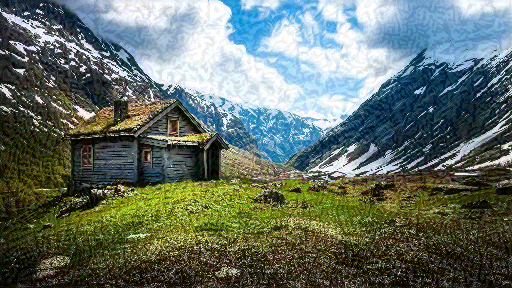

In [168]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

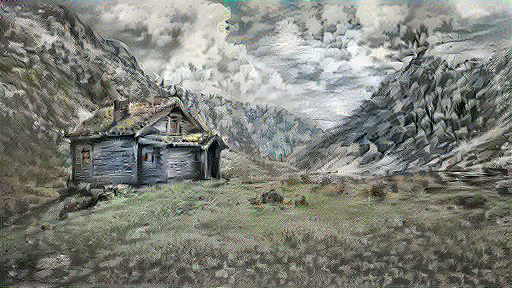

Train Step: 1000
Total time: 25.7


In [169]:
# Run for more epochs

import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print('.', end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print(f"Train Step: {step}")

end = time.time()
print(f'Total time: {(end-start):.1f}')

## Total Variation Loss

This implementation encounters a lot of High Frequency artificats, which can be reduced using a regularization term.

In [170]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[: , :-1, :, :]
  return x_var, y_var

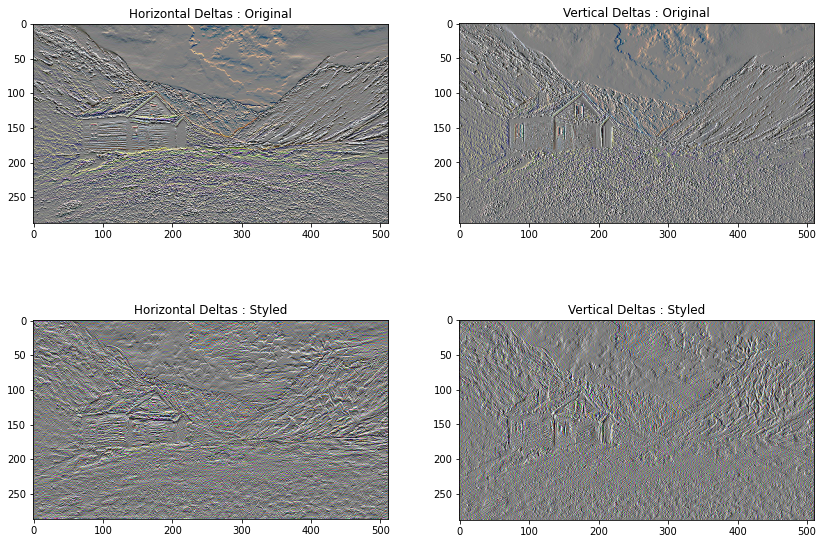

In [171]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize = (14, 10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas : Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas : Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas : Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas : Styled")

All the High Frequency terms are increased.

In [172]:
sobel = tf.image.sobel_edges(content_image)

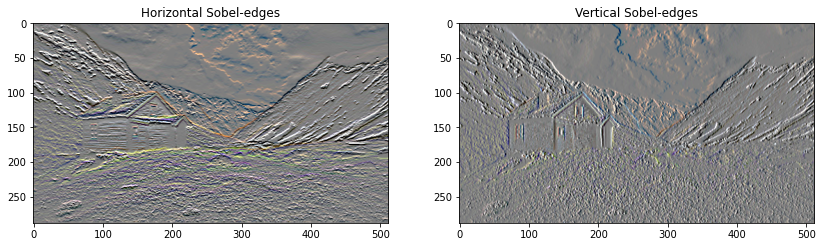

In [173]:
plt.figure(figsize=(14,10))

plt.subplot(1,2,1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")

plt.subplot(1,2,2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [174]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [175]:
## Manual Function
total_variation_loss(image).numpy()

104379.56

In [176]:
## Similar fuction provided by Tensorflow
tf.image.total_variation(image).numpy()

array([104379.56], dtype=float32)

In [177]:
# Weight for loss
total_variation_weight = 30

In [178]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight * tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))


In [179]:
image = tf.Variable(content_image)

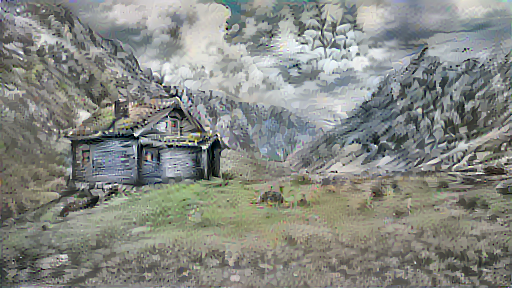

Train Step: 1000
Total time: 27.2


In [180]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print('.', end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print(f"Train Step: {step}")

end = time.time()
print(f'Total time: {(end-start):.1f}')

In [182]:
file_name = 'neural-style-transfer.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except:
  pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>